In [68]:
from base import *
from utils import pauli_sum, entropy
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The Two qubit systems
$$
H_{\mathrm{I}}=H_x\sigma_x\otimes\sigma_x+H_z\sigma_z\otimes\sigma_z,
$$

In [69]:
# Constant
Hx = 2.0
Hz = 3.0

# H_0
H0_coeff = np.array([0.0, 2.5, 6.5, 7.0])
H0 = np.diag(H0_coeff)


H1 = np.array([[Hz, 0, 0, 0],
            [0, -Hz, Hx, 0],
            [0,  Hx, -Hz, 0],
            [Hx, 0, 0, + Hz]])
H0

array([[0. , 0. , 0. , 0. ],
       [0. , 2.5, 0. , 0. ],
       [0. , 0. , 6.5, 0. ],
       [0. , 0. , 0. , 7. ]])

### Classical numerical solver for the eigenvalues and the Von Neumann entropy 

$$
S(A,B)=-\mathrm{Tr}\left(\rho_{A,B}\log_2 (\rho_{A,B})\right).
$$

In [70]:
def H(lmb):
    return H0 + lmb * H1

# def partial_trace(state, i):
'''deprecated, replaced by np.einsum'''
#     state0 = np.array([1,0])
#     state1 = np.array([0,1])
#     density = np.outer(state, np.conj(state))
#     op0 = np.kron(state0, I) if i == 0 else np.kron(I, state0)
#     op1 = np.kron(state1, I) if i == 0 else np.kron(I, state1)
#     return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T



lmbs = np.arange(0, 1, 0.001)
eigs = np.zeros((4, len(lmbs)))
entropies = np.zeros((4, len(lmbs)))
vn_entropies = np.zeros((4, len(lmbs)))

for i, lmb in enumerate(lmbs):
    ham = H(lmb)
    eigvals, eigvecs = np.linalg.eig(ham)
    eigs[:,i] = sorted(eigvals)
    lmb_entropy = np.zeros(4)
    # vn_entropies[:,i] = entropy(ham, np.arange(4))[0] # returns both, doesn't matter which one you take
    vn_entropies[:,i] = entropy(ham, 0)[0]




In [71]:
plot_2D(lmbs, eigs, plot_count=4, title="Numerical Eigenvalues-2", x_title=r'$\lambda$', y_title='Energies',label=[r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'], filename='eigs-2-cl.pdf')
plot_2D(lmbs, vn_entropies, plot_count=4, title="Entropies", x_title=r'$\lambda$', y_title='Entropies',filename='entropies-2-cl.pdf')

### VQE

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$ H_0 = \begin{bmatrix}
    0 & 0 & 0 & 0  \\
    0 & 2.5 & 0 & 0  \\
    0 & 0 & 6.5 & 0 \\
    0 & 0 & 0 & 7 
    \end{bmatrix}
$$

Rewrite $H_0$ in terms of the computational basis $Z$ and $I$.
$$
    H_0 = a I\otimes I + b I\otimes Z + cZ\otimes I + dZ\otimes Z,
$$
Solving the above equations, we get
$$
a = 4, b = -0.75, c = -2.75, d = -0.5
$$

and using the gates we have to switch to the computational basis $Z \otimes I$ we have:

Let the swap gate be denoted by $\mathcal{S}$, and cnot gate with control on qubit 1 and target on qubit 0 be $\mathcal{CN}$.
$$
\newcommand{\swap}{\mathcal{S}} 
\newcommand{\cnot}{\mathcal{CN}(1,0)} 
$$
$$ 
H_0 = 4 I\otimes I + -0.75 (\swap Z \otimes I \swap) + -2.75 Z\otimes I + -0.5 (\cnot Z \otimes I \cnot) 
$$

$$
H_{\mathrm{I}}=H_x\sigma_x\otimes\sigma_x+H_z\sigma_z\otimes\sigma_z,
$$H
Rewrite $X$ into $I \otimes Z$
$$
H_I = H_x (I \otimes \sigma_z) (\sigma_z \otimes I) + H_z (\sigma_z \otimes I) (I \otimes \sigma_z)
$$

$$
H_I = \lambda (Hx \swap Z \otimes I \swap) + \lambda (Hz \cnot Z \otimes I \cnot)
$$

$$
\begin{aligned}
H = H_0 + H_I = &4 \: I\otimes I \\
&+ (-0.75 + \lambda Hx) \: (\swap Z \otimes I \swap) \\
&+ -2.75 \: Z \otimes I \\
&+ (-0.5 + \lambda Hz) \:(\cnot Z \otimes I \cnot) \\
\end{aligned}


In [72]:
def H(lmb): 
    return PauliSumOp.from_list([('II', 4),
                                 ('IZ', (-0.75)),
                                 ('ZI', (-2.75)),
                                 ('ZZ', (-0.5 + lmb * Hz)),
                                 ('XX', (lmb * Hx))])

H(0)


PauliSumOp(SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 4.  +0.j, -0.75+0.j, -2.75+0.j, -0.5 +0.j,  0.  +0.j]), coeff=1.0)

Set up

In [73]:
def ansatz():
    '''creates an ansatz for vqe
    inputs:
        n: int, number of qubits
    return:
        qc: QuantumCircuit object, parametrized quantum circuit with given number of qubits, with parameters 
        thetas and phis
        '''
    # TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    n=2
    qc = QuantumCircuit(n)
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')

    qc.rx(theta0,0)
    qc.ry(phi0,0)
    qc.rx(theta1,1)
    qc.ry(phi1,1)
    
    return qc

def prep_vqe(n):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2*n), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [74]:
n_points=1000
n_qubits=2

lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




lmb = 0.0, energy = 3.974107831705709e-08
lmb = 0.001, energy = 0.0030000391120288874
lmb = 0.002, energy = 0.006000038404872921
lmb = 0.003, energy = 0.009000404683656963
lmb = 0.004, energy = 0.012000399612154617
lmb = 0.005, energy = 0.015000394226695881
lmb = 0.006, energy = 0.018000388450068218
lmb = 0.007, energy = 0.021000382418485723
lmb = 0.008, energy = 0.024000376100457306
lmb = 0.009, energy = 0.027000369506598954
lmb = 0.01, energy = 0.030000362714819546
lmb = 0.011, energy = 0.033000355584111525
lmb = 0.012, energy = 0.03600034832798877
lmb = 0.013, energy = 0.039000340857249606
lmb = 0.014, energy = 0.042000333320821745
lmb = 0.015, energy = 0.04500032555899935
lmb = 0.016, energy = 0.04800031775230347
lmb = 0.017, energy = 0.051000309758152555
lmb = 0.018, energy = 0.054000301781340035
lmb = 0.019, energy = 0.05700029368212548
lmb = 0.02, energy = 0.06000028554421676
lmb = 0.021, energy = 0.06300027742476524
lmb = 0.022, energy = 0.0660002692978568
lmb = 0.023, energy =

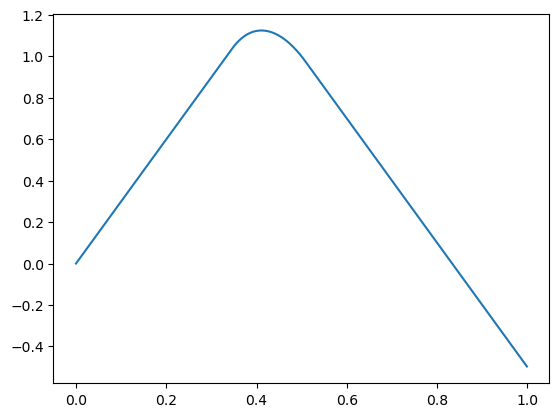

In [75]:
plt.plot(lmbs/n_points, energies)
# plot_2D(lmbs/n_points, energies, title="Ground State Energy for 2 qubits with qiskit", x_title=r'$\lambda$', y_title='Energy',
        # filename='qk-2.pdf'), 
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
\begin{aligned}
H = H_0 + H_I = &4 \: I\otimes I \\
&+ (-0.75 ) \: (\swap Z \otimes I \swap) \\
&+ -2.75 \: Z \otimes I \\
&+ (-0.5 + \lambda Hz) \:(\cnot Z \otimes I \cnot) \\
&+ \lambda Hx \: (H \otimes H \cnot Z \otimes I \cnot H \otimes H)
\end{aligned}

In [76]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qc = Qubits_2()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    # qc.cnot(0, 1)
    return qc

def my_H(lmb):
    return pauli_sum([('II', 4),
            ('IZ', (-0.75)),
            ('ZI', (-2.75)),
            ('ZZ', (-0.5 + lmb * Hz)),
            ('XX', (lmb * Hx))])

def expectation(qc, lmb, n_shots=10000):
    '''the expectation value of energy for the hamiltonian'''
    coeffs = {'II':4, 'IZ':-0.75, 'ZI':-2.75, 'ZZ': -0.5 + lmb * Hz, 'XX':lmb * Hx}
    qc_copy = qc.copy()

    # IZ
    qc_copy.swap() 
    count_iz = qc_copy.measure(n_shots=n_shots)[:,0] # only the couonts, don't keep the states

    # ZI
    qc_copy = qc.copy() # make a new copy everytime
    count_zi = qc_copy.measure(n_shots=n_shots)[:,0]

    # ZZ
    qc_copy = qc.copy()
    qc_copy.cnot(1,0)
    count_zz = qc_copy.measure(n_shots=n_shots)[:,0]

    # XX
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)

    count_xx = qc_copy.measure(n_shots=n_shots)[:,0]

    expectaions = 0
    # ZI = (#00 + #01 - #10 - #11)/ number of shots
    # print(count_iz, count_zi, count_zz, count_xx)
    counts = [coeffs['IZ'] * count_iz, coeffs['ZI'] * count_zi, 
              coeffs['ZZ'] * count_zz, coeffs['XX'] * count_xx]
    # print(counts)
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            if i < 2:
                expectaions += state_count
            else:
                expectaions -= state_count
    return coeffs['II'] + expectaions / n_shots


qc = Qubits_2()
expectation(qc, 0.5)


1.4928

In [77]:
a = my_ansatz(np.ones(4)* np.random.uniform(low=-np.pi/2, high=np.pi/2))
a

Qubit(s) in state: 
 0.90+0.10j|00⟩ + -0.22+0.20j|01⟩ + -0.22+0.20j|10⟩ + 0.00-0.10j|11⟩ 

In [78]:
from algorithms import Vqe 

In [79]:
n_points = 1000

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=4)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    my_ham = my_H(lmb)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, lmb)
    print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy



lambda: 0.0, energy: 0.0
lambda: 0.001, energy: 0.0029492187500004263
lambda: 0.002, energy: 0.00583593750000011
lambda: 0.003, energy: 0.00858984375000027
lambda: 0.004, energy: 0.011609375000000366
lambda: 0.005, energy: 0.01517578124999952
lambda: 0.006, energy: 0.017953125000000014
lambda: 0.007, energy: 0.02089062499999983
lambda: 0.008, energy: 0.02418750000000003
lambda: 0.009, energy: 0.026367187500000444
lambda: 0.01, energy: 0.029414062499999893
lambda: 0.011, energy: 0.03196874999999988
lambda: 0.012, energy: 0.03478124999999954
lambda: 0.013, energy: 0.03859374999999998
lambda: 0.014, energy: 0.04107031250000004
lambda: 0.015, energy: 0.04400390624999995
lambda: 0.016, energy: 0.046624999999999694
lambda: 0.017, energy: 0.050207031250000256
lambda: 0.018, energy: 0.05203124999999975
lambda: 0.019, energy: 0.055490234375000114
lambda: 0.02, energy: 0.057656249999999964
lambda: 0.021, energy: 0.06193359375000007
lambda: 0.022, energy: 0.06316406249999984
lambda: 0.023, energy

In [80]:
lmbs = lmbs/n_points
plot_2D(lmbs, [my_energies,energies], plot_count=2, title='VQE for 2 qubit systems', x_title=r'$\lambda$', y_title='Eigenvalues', label=['vqe-base','vqe-qk'], filename='vqe-2.pdf')
